# Building Blocks

Here we will go step by step building my implementation of tensorflow's wide and deep algorithm using pytorch, and adding a few extras. Needless to say, all credit for the original algorithm to Heng-Tze Cheng et al. Their paper can be found [here](https://arxiv.org/pdf/1606.07792.pdf) and the tutorial [here](https://www.tensorflow.org/tutorials/wide_and_deep).

## The model

The original model is a combination of a linear classifier/regressor for sparse features (Wide) plus a neural network classifier/regressor that receives the embeddings (Deep). Here I have simply "enhanced" the algorithm so it can take images and text. The figure below is my attempt of describing what is going on.

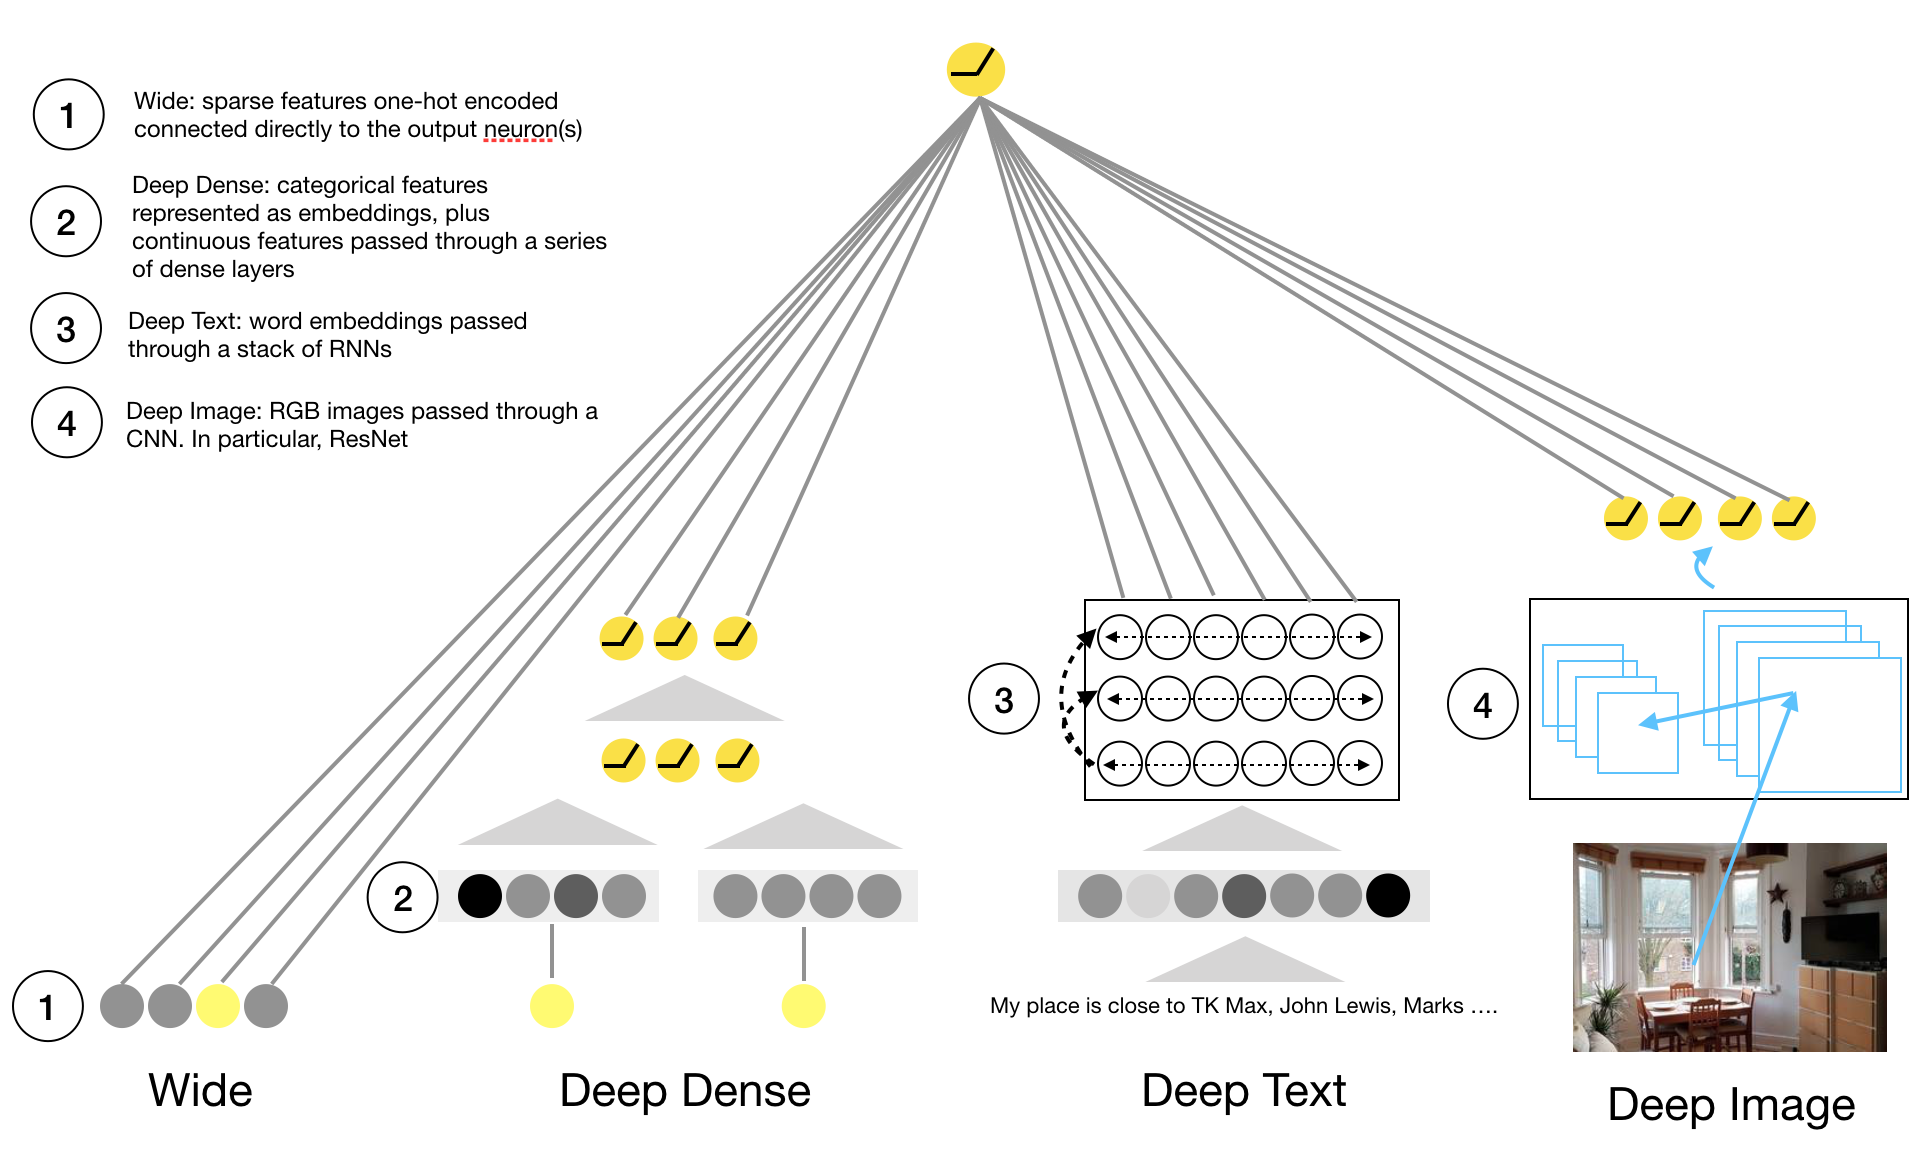

In [1]:
from IPython.display import Image
PATH = "WideDeeper.png"
Image(filename = PATH, width=900, height=400)

Before we jump to the code, let's just have a look to the key expression in their paper, and is adaptation here. Expression 3 in the paper is:

$$
P(Y = 1|x) = \sigma(W^{T}_{wide}[x, \phi(x)] + W^{T}_{deep}a^{(l_f)} + b)
$$

Where $Y$ is the binary class label (in their case they perform a logistic regression),  $\sigma(\cdot)$ is the activation function, in their case Sigmoid, $\phi(x)$ are the cross product transformations of the original features $x$, and $b$ is the bias term. $W_{wide}$ is the vector of all wide model weights, and $W_{deep}$ are the weights applied on the final activations $a^{(l_f)}$. 

My adaptation is simply:

$$
target = \sigma(W^{T}_{wide}[x, \phi(x)] + W^{T}_{deep-dense}a_{dense}^{(l_f)} + W^{T}_{deep-text}h_{last} + W^{T}_{deep-image}a_{image}^{(l_f)} +  b)
$$

Where $target$ can be the target of a logistic regression, multiclass classification or a regression problem. $h_{last} $ is the last hidden state of the stacked RNNs and $a_{image}^{(l_f)}$ are the final activations of the last fully connected layer of what is often referred as the CNN "Head" (the rest of the terms in the expression are self explanatory). 

Let's now move to the code

## 1. Wide

The wide part consist simply in the sparse features connected directly to the output neuron (or neurons if the problem is a multiclass classification). Assuming that we perform a logistic regression or a regression, we need to connect the input features to an output neuron and use a *Sigmoid* activation function if logistic regression or no activation at all if regression. 

In our case, this could be done like this:

In [2]:
import torch
import torch.nn as nn
from torch import Tensor

class Wide(nn.Module):
    def __init__(self, wide_dim, output_dim):
        super(Wide, self).__init__()
        self.wlinear = nn.Linear(wide_dim, output_dim)

    def forward(self, X):
        out = self.wlinear(X)
        return out

As I mentioned in demo1, the results of preparing the data are saved in a dictionary. Let's load that dictionary to illustrate the use of each component. 

In [3]:
import pickle

wd_adult = pickle.load(open("data/adult/wide_deep_data/wd_dataset.p", "rb"))
print(list(wd_adult.keys()))

['train', 'valid', 'test', 'cat_embeddings_input', 'cat_embeddings_encoding_dict', 'continuous_cols', 'deep_column_idx']


In the dictionary we have the train, validation and test datasets plus a series of useful information to build the model, as we will see before. Just mention that the dictionary structure will be almost identical for the Airbnb dataset, only that the train, validation and test datasets will include the numericalised texts and the resized images. Let's have a look to the Wide component of the datasets

In [4]:
print(wd_adult['train']['wide'].shape)
wd_adult['train']['wide'][:5]

(29305, 805)


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

As expected, a sparse matrix of the one hot encoded categorical features. Let's just run the Wide model

In [5]:
wide_batch = torch.from_numpy(wd_adult['train']['wide'][:4])
wide = Wide(wide_dim=805, output_dim=1)
out = wide(wide_batch)
out

tensor([[-0.0270],
        [-0.0300],
        [-0.0088],
        [ 0.0223]], grad_fn=<AddmmBackward>)

## 2. Deep-Dense

Here the model is a little more complex, let's have a look

In [6]:
def dense_layer(inp, out, dropout):
    return nn.Sequential(
        nn.Linear(inp, out),
        nn.LeakyReLU(inplace=True),
        nn.Dropout(dropout)
        )

class DeepDense(nn.Module):
    def __init__(self, embeddings_input, embeddings_encoding_dict, continuous_cols,
        deep_column_idx, hidden_layers, dropout, output_dim):
        super(DeepDense, self).__init__()

        self.embeddings_input = embeddings_input
        self.embeddings_encoding_dict = embeddings_encoding_dict
        self.continuous_cols = continuous_cols
        self.deep_column_idx = deep_column_idx

        for col,val,dim in embeddings_input:
            setattr(self, 'emb_layer_'+col, nn.Embedding(val, dim))
        input_emb_dim = np.sum([emb[2] for emb in embeddings_input]) +len(continuous_cols)
        hidden_layers = [input_emb_dim] + hidden_layers
        dropout = [0.0] + dropout
        self.dense = nn.Sequential()
        for i in range(1, len(hidden_layers)):
            self.dense.add_module(
                'dense_layer_{}'.format(i-1),
                dense_layer( hidden_layers[i-1], hidden_layers[i], dropout[i-1])
                )
        self.dense.add_module('last_linear', nn.Linear(hidden_layers[-1], output_dim))

    def forward(self, X:Tensor)->Tensor:
        emb = [getattr(self, 'emb_layer_'+col)(X[:,self.deep_column_idx[col]].long())
               for col,_,_ in self.embeddings_input]
        if self.continuous_cols:
            cont_idx = [self.deep_column_idx[col] for col in self.continuous_cols]
            cont = [X[:, cont_idx].float()]
            inp = torch.cat(emb+cont, 1)
        else:
            inp = torch.cat(emb, 1)
        out = self.dense(inp)
        return out

Let's go step by step using the wd_adult to understand the class constructor and what the forward pass does. 

The first arguments in the constructor are: `embeddings_input`, `embeddings_encoding_dict`, `continuous_cols` and `deep_column_idx`. These are all in the dictionary and look like this

In [7]:
# embeddings_input: the set up in terms of number of unique values and embedding dimension
wd_adult['cat_embeddings_input']

[('education', 16, 10),
 ('relationship', 6, 8),
 ('workclass', 9, 10),
 ('occupation', 15, 10),
 ('native_country', 42, 10)]

In [8]:
# The embedding mappings, required later because once the model has run we want to recover the embeddings.
# For example, one might hope that the embeddings of 'Masters' resemble more to those of "Doctorate" that 
# 'Preschool'
wd_adult['cat_embeddings_encoding_dict']

{'education': {'11th': 0,
  'HS-grad': 1,
  'Assoc-acdm': 2,
  'Some-college': 3,
  '10th': 4,
  'Prof-school': 5,
  '7th-8th': 6,
  'Bachelors': 7,
  'Masters': 8,
  'Doctorate': 9,
  '5th-6th': 10,
  'Assoc-voc': 11,
  '9th': 12,
  '12th': 13,
  '1st-4th': 14,
  'Preschool': 15},
 'relationship': {'Own-child': 0,
  'Husband': 1,
  'Not-in-family': 2,
  'Unmarried': 3,
  'Wife': 4,
  'Other-relative': 5},
 'workclass': {'Private': 0,
  'Local-gov': 1,
  '?': 2,
  'Self-emp-not-inc': 3,
  'Federal-gov': 4,
  'State-gov': 5,
  'Self-emp-inc': 6,
  'Without-pay': 7,
  'Never-worked': 8},
 'occupation': {'Machine-op-inspct': 0,
  'Farming-fishing': 1,
  'Protective-serv': 2,
  '?': 3,
  'Other-service': 4,
  'Prof-specialty': 5,
  'Craft-repair': 6,
  'Adm-clerical': 7,
  'Exec-managerial': 8,
  'Tech-support': 9,
  'Sales': 10,
  'Priv-house-serv': 11,
  'Transport-moving': 12,
  'Handlers-cleaners': 13,
  'Armed-Forces': 14},
 'native_country': {'United-States': 0,
  '?': 1,
  'Peru': 2

In [9]:
# Not much secret here
wd_adult['continuous_cols']

['age', 'hours_per_week']

In [10]:
# These are the indexes of the columns in the corresponding Deep dataset. 
# Note that since there is no text and images in the adult dataset, I simply 
# refer to the deep-dense side as 'deep'
wd_adult['deep_column_idx']

{'education': 0,
 'relationship': 1,
 'workclass': 2,
 'occupation': 3,
 'native_country': 4,
 'age': 5,
 'hours_per_week': 6}

In [11]:
wd_adult['train']['deep'][:4]

array([[ 1.        ,  1.        ,  0.        ,  0.        ,  0.        ,
         0.31774596, -0.03408696],
       [ 3.        ,  1.        ,  0.        ,  8.        ,  0.        ,
         0.02599598,  0.77292975],
       [ 1.        ,  1.        ,  0.        ,  0.        ,  0.        ,
         1.33887088, -0.03408696],
       [ 6.        ,  1.        ,  0.        , 12.        ,  0.        ,
         0.53655844, -0.03408696]])

Let's now have a look to what happens inside the model class constructor

In [ ]:
# DO NOT RUN!

# for column name, number of unique values and embedding dimensions, we set the embeddings for the categorical cols
for col,val,dim in embeddings_input:
    setattr(self, 'emb_layer_'+col, nn.Embedding(val, dim))

# The input to the series of dense layers will have the dimension result of concatenating all embeddings plus the 
# continuous cols
input_emb_dim = np.sum([emb[2] for emb in embeddings_input]) +len(continuous_cols)

# the input hidden_layers will be a list like: [100, 50]. This simply means that there will be a 100 units dense layer 
# connected to a 50 units dense layer which will be in itself connected to the output neuron(s)
hidden_layers = [input_emb_dim] + hidden_layers

# We will not include dropout between the categorical embeddings and the first layer
dropout = [0.0] + dropout

# From now on is pretty straighforward
self.dense = nn.Sequential()
for i in range(1, len(hidden_layers)):
    self.dense.add_module(
        'dense_layer_{}'.format(i-1),
        dense_layer( hidden_layers[i-1], hidden_layers[i], dropout[i-1])
        )
self.dense.add_module('last_linear', nn.Linear(hidden_layers[-1], output_dim))

Let's build the model for real

In [12]:
import numpy as np
deep_batch = torch.from_numpy(wd_adult['train']['deep'][:4])
deep = DeepDense(
    embeddings_input = wd_adult['cat_embeddings_input'], 
    embeddings_encoding_dict= wd_adult['cat_embeddings_encoding_dict'], 
    continuous_cols = wd_adult['continuous_cols'],
    deep_column_idx = wd_adult['deep_column_idx'], 
    hidden_layers = [32, 16], 
    dropout = [0.5], 
    output_dim=1)

In [13]:
deep

DeepDense(
  (emb_layer_education): Embedding(16, 10)
  (emb_layer_relationship): Embedding(6, 8)
  (emb_layer_workclass): Embedding(9, 10)
  (emb_layer_occupation): Embedding(15, 10)
  (emb_layer_native_country): Embedding(42, 10)
  (dense): Sequential(
    (dense_layer_0): Sequential(
      (0): Linear(in_features=50, out_features=32, bias=True)
      (1): LeakyReLU(negative_slope=0.01, inplace)
      (2): Dropout(p=0.0)
    )
    (dense_layer_1): Sequential(
      (0): Linear(in_features=32, out_features=16, bias=True)
      (1): LeakyReLU(negative_slope=0.01, inplace)
      (2): Dropout(p=0.5)
    )
    (last_linear): Linear(in_features=16, out_features=1, bias=True)
  )
)

In [14]:
out = deep(deep_batch)
out

tensor([[0.1839],
        [0.1795],
        [0.3327],
        [0.1683]], grad_fn=<AddmmBackward>)

Let's now move onto the text and image models.

## 3. Deep-Text

Here we will need the Airbnb dataset

In [15]:
wd_airbnb = pickle.load(open("data/airbnb/wide_deep_data/wd_dataset.p", "rb"))

In [16]:
print(list(wd_airbnb.keys()))

['train', 'valid', 'test', 'vocab', 'word_embeddings_matrix', 'cat_embeddings_input', 'cat_embeddings_encoding_dict', 'continuous_cols', 'deep_column_idx']


In [17]:
print(list(wd_airbnb['train'].keys()))

['wide', 'deep_dense', 'deep_text', 'deep_img', 'target']


Let's concentrate in the `deep_text` and `deep_img` inputs.

In [18]:
wd_airbnb['train']['deep_text'][:5]

array([[   1,    1,    1,    1, ...,  471,  463,    5,   78],
       [  27,   12,  161,  457, ..., 1036,    5,  413,    9],
       [  50,   46,  358,  130, ...,   15,   64,    5,  573],
       [ 235,  154,   66,   68, ...,   11,  219,   16,  157],
       [  12,  102,   14,   82, ...,  372,   11,    5,    0]])

sequences of 170 (I chose this number, you can chose you sequences to be as long/short as you want) integers that are our numericalised tokens. Let's have a look to the model

In [19]:
class DeepText(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, n_layers, rnn_dropout, 
                 padding_idx, output_dim, bidirectional=False, embedding_matrix=None):
        super(DeepText, self).__init__()
        """
        Standard Text Classifier/Regressor with a stack of RNNs.
        """

        self.bidirectional = bidirectional
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = padding_idx)
        if isinstance(embedding_matrix, np.ndarray):
            self.embedding.weight = nn.Parameter(torch.Tensor(embedding_matrix))
        self.rnn = nn.GRU(embedding_dim,
            hidden_dim,
            num_layers=n_layers,
            bidirectional=bidirectional,
            dropout=rnn_dropout,
            batch_first=True)
        input_dim = hidden_dim*2 if bidirectional else hidden_dim
        self.dtlinear = nn.Linear(input_dim, output_dim)


    def forward(self, X):

        embedded = self.embedding(X)
        o, h = self.rnn(embedded)
        if self.bidirectional:
            last_h = torch.cat((h[-2], h[-1]), dim = 1)
        else:
            last_h = h[-1]
        out = self.dtlinear(last_h)
        return out

The implementation in the module `widedeep` includes some adds on, like spatial dropout for the embeddings and soft alignment attention, which I took from [here](https://github.com/prakashpandey9/Text-Classification-Pytorch/blob/master/models/LSTM_Attn.py). There are many resources to read about attention. One could start [here](https://machinelearningmastery.com/how-does-attention-work-in-encoder-decoder-recurrent-neural-networks/) and references therein. 

In this case I would say that the model is pretty straightforward, similar to most text classification models you will find out there. A n layers stack of GRUs that receives the word embeddings and passes the last hidden state to the ouput layer. Let's build it and run it. 

In [20]:
from fastai.text import  Vocab
deep_text_batch = torch.from_numpy(wd_airbnb['train']['deep_text'][:4])
deep_text = DeepText(
    vocab_size = len(wd_airbnb['vocab'].itos), 
    embedding_dim=300, 
    hidden_dim=64, 
    n_layers=3,
    rnn_dropout=0.5, 
    padding_idx=1, 
    output_dim=1)

In [21]:
deep_text

DeepText(
  (embedding): Embedding(7177, 300, padding_idx=1)
  (rnn): GRU(300, 64, num_layers=3, batch_first=True, dropout=0.5)
  (dtlinear): Linear(in_features=64, out_features=1, bias=True)
)

In [22]:
out = deep_text(deep_text_batch)
out

tensor([[ 0.0483],
        [-0.0710],
        [-0.0732],
        [-0.0055]], grad_fn=<AddmmBackward>)

And finally, to the images

## Deep-Image

In [23]:
wd_airbnb['train']['deep_img'][0].shape

(224, 224, 3)

here again, the model is not complex

In [24]:
import torch.nn.functional as F
from torchvision import models

def conv_layer(ni, nf, ks=3, stride=1, maxpool=True, adaptiveavgpool=False):
    layer = nn.Sequential(
        nn.Conv2d(ni, nf, kernel_size=ks, bias=True, stride=stride, padding=ks//2),
        nn.BatchNorm2d(nf, momentum=0.01),
        nn.LeakyReLU(negative_slope=0.1, inplace=True))
    if maxpool: layer.add_module('maxpool', nn.MaxPool2d(2, 2))
    if adaptiveavgpool: layer.add_module('adaptiveavgpool', nn.AdaptiveAvgPool2d(output_size=(1, 1)))
    return layer


class DeepImage(nn.Module):

    def __init__(self, output_dim=1, pretrained=True):
        super(DeepImage, self).__init__()
        if pretrained:
            vision_model = models.resnet18(pretrained=True)
            self.backbone = nn.Sequential(*list(vision_model.children())[:-1])
        else:
            self.backbone = nn.Sequential(
                conv_layer(3, 64, 3),
                conv_layer(64, 128, 1, maxpool=False),
                conv_layer(128, 256, 1, maxpool=False),
                conv_layer(256, 512, 1, maxpool=False, adaptiveavgpool=True),
                )
        self.fc1 = nn.Linear(512, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 1)

    def forward(self, x):
        x = self.backbone(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

As a "backbone", we use resnet18 (or 34, or whichever resnet you prefer, but has to be resnet, since the set up assumes 224x224 images as input and 512 as the output from the convolutions). The implementation in the `widedeep` module includes the option to unfreeze some of the last layers in the resnet architecture

If for some "obscure" reason you prefer to not use a pretrained model, I have included a sequential model comprised by 3 convolutional blocks.  

Let's build the model and have a look

In [25]:
deep_img_batch = torch.from_numpy((wd_airbnb['train']['deep_img'][:4]/255).astype('float32')) #normalize to 0-1

In [26]:
deep_img_batch = deep_img_batch.permute(0,3,1,2) # torch takes channel,H,W
deep_img_batch.shape

torch.Size([4, 3, 224, 224])

In a real example, one would have to subtract the mean and std corresponding to the ImageNet if you use the pretrained ResNet architecture, or the one corresponding to your training dataset (all this is included in the `prepare_data_airbnb` function). Here I will skip that step since I just want to confirm/illustrate that the model runs well

In [27]:
deep_img = DeepImage(
    output_dim=1, 
    pretrained=True)

In [28]:
deep_img #ResNet18

DeepImage(
  (backbone): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      

In [29]:
deep_img(deep_img_batch)

tensor([[ 0.0169],
        [-0.0010],
        [ 0.1355],
        [ 0.0695]], grad_fn=<AddmmBackward>)

At this point, the only thing left is create "the monster", i.e. combine all the parts. 

## Wide and Deep...er

I will include here just a fraction of all the things that the WideDeep class at `widedeep/models/wide_deep.py` does. The Wide and Deep there includes the possibility of using different optimizers and learning rates schedulers for each component (wide, deep-dense, deep-text and deep-dimages). The training, evaluation and prediction phases are included in the class' methods and there is an additional method to recover the embeddings for the categorical features in the DeepDense model. 

Let's show here the "core" of our Wide and Deep model:

In [30]:
def set_method(method):
    if method =='regression':
        return None, F.mse_loss
    if method =='logistic':
        return torch.sigmoid, F.binary_cross_entropy
    if method=='multiclass':
        return F.softmax, F.cross_entropy


def set_optimizer(model_params, opt_params):
    try:
        opt, lr, m = opt_params
    except:
        opt, lr = opt_params
    if opt == "Adam":
        return torch.optim.Adam(model_params, lr=lr)
    if opt == "Adagrad":
        return torch.optim.Adam(model_params, lr=lr)
    if opt == "RMSprop":
        return torch.optim.RMSprop(model_params, lr=lr, momentum=m)
    if opt == "SGD":
        return torch.optim.SGD(model_params, lr=lr, momentum=m)

    
class WideDeep(nn.Module):
    def __init__(self, output_dim, **params):
        super(WideDeep, self).__init__()

        self.datasets = {}
        self.output_dim = output_dim
        self.n_datasets = 1
        for k,v in params['wide'].items():
            setattr(self, k, v)
        self.wide = Wide(
            self.wide_dim,
            self.output_dim
            )
        if 'deep_dense' in params.keys():
            self.datasets['deep_dense'] = self.n_datasets
            self.n_datasets+=1
            for k,v in params['deep_dense'].items():
                setattr(self, k, v)
            self.deep_dense = DeepDense(
                self.embeddings_input,
                self.embeddings_encoding_dict,
                self.continuous_cols,
                self.deep_column_idx,
                self.hidden_layers,
                self.dropout,
                self.output_dim
                )
        if 'deep_text' in params.keys():
            self.datasets['deep_text'] = self.n_datasets
            self.n_datasets+=1
            for k,v in params['deep_text'].items():
                setattr(self, k, v)
            self.deep_text = DeepText(
                self.vocab_size,
                self.embedding_dim,
                self.hidden_dim,
                self.n_layers,
                self.dropout,
                self.padding_idx,
                self.output_dim
                )
        if 'deep_img' in params.keys():
            self.datasets['deep_img'] = self.n_datasets
            self.n_datasets+=1
            for k,v in params['deep_img'].items():
                setattr(self, k, v)
            self.deep_img = DeepImage(
                self.output_dim,
                self.pretrained
                )

    def compile(self, method, optimizer):

        self.method = method
        self.activation, self.criterion = set_method(method)
        self.optimizer = set_optimizer(self.parameters(), optimizer)
        
    def forward(self, X):

        wide_inp = X[0]
        wide_deep = self.wide(wide_inp)
        if 'deep_dense' in self.datasets.keys():
            deep_dense_idx = self.datasets['deep_dense']
            deep_dense_out = self.deep_dense(X[deep_dense_idx])
            wide_deep.add_(deep_dense_out)
        if 'deep_text' in self.datasets.keys():
            deep_text_idx = self.datasets['deep_text']
            deep_text_out = self.deep_text(X[deep_text_idx])
            wide_deep.add_(deep_text_out)
        if 'deep_img' in self.datasets.keys():
            deep_img_idx = self.datasets['deep_img']
            deep_img_out = self.deep_img(X[deep_img_idx])
            wide_deep.add_(deep_img_out)

        if not self.activation:
            return wide_deep
        else:
            if (self.activation==F.softmax):
                out = self.activation(wide_deep, dim=1)
            else:
                out = self.activation(wide_deep)
            return out

In [31]:
params = dict()
params['wide'] = dict(
    wide_dim = wd_airbnb['train']['wide'].shape[1]
    )
params['deep_dense'] = dict(
    embeddings_input = wd_airbnb['cat_embeddings_input'],
    embeddings_encoding_dict = wd_airbnb['cat_embeddings_encoding_dict'],
    continuous_cols = wd_airbnb['continuous_cols'],
    deep_column_idx = wd_airbnb['deep_column_idx'],
    hidden_layers = [32,16],
    dropout = [0.5]
    )
params['deep_text'] = dict(
    vocab_size = len(wd_airbnb['vocab'].itos),
    embedding_dim = wd_airbnb['word_embeddings_matrix'].shape[1],
    hidden_dim = 32,
    n_layers = 3,
    dropout = 0.5,
    padding_idx = 1
    )
params['deep_img'] = dict(
    pretrained = True
    )

In [32]:
wide_deep = WideDeep(output_dim=1, **params)

In [33]:
# And here it is
wide_deep

WideDeep(
  (wide): Wide(
    (wlinear): Linear(in_features=213, out_features=1, bias=True)
  )
  (deep_dense): DeepDense(
    (emb_layer_minimum_nights_catg): Embedding(3, 16)
    (emb_layer_guests_included_catg): Embedding(3, 16)
    (emb_layer_accommodates_catg): Embedding(3, 16)
    (emb_layer_bathrooms_catg): Embedding(3, 16)
    (emb_layer_bedrooms_catg): Embedding(4, 16)
    (emb_layer_host_listings_count_catg): Embedding(4, 16)
    (emb_layer_beds_catg): Embedding(4, 16)
    (dense): Sequential(
      (dense_layer_0): Sequential(
        (0): Linear(in_features=116, out_features=32, bias=True)
        (1): LeakyReLU(negative_slope=0.01, inplace)
        (2): Dropout(p=0.0)
      )
      (dense_layer_1): Sequential(
        (0): Linear(in_features=32, out_features=16, bias=True)
        (1): LeakyReLU(negative_slope=0.01, inplace)
        (2): Dropout(p=0.5)
      )
      (last_linear): Linear(in_features=16, out_features=1, bias=True)
    )
  )
  (deep_text): DeepText(
    (emb

In [34]:
wide_batch = torch.from_numpy(wd_airbnb['train']['wide'][:4])
deep_dense_batch = torch.from_numpy(wd_airbnb['train']['deep_dense'][:4])
wide_deep_batch = (wide_batch, deep_dense_batch, deep_text_batch, deep_img_batch)

In [35]:
wide_deep.compile(method='regression', optimizer=["Adam", 0.01])
wide_deep(wide_deep_batch)

tensor([[ 0.3741],
        [-0.6823],
        [-0.7033],
        [-0.9187]], grad_fn=<AddBackward0>)